In [1]:
%pylab inline
import numpy as np
import scipy as sc
import scipy.ndimage as ndi
import pylab as pl
import matplotlib as mpl
from IPython import display
from itertools import islice
rc("image", cmap="gray")

Populating the interactive namespace from numpy and matplotlib


# Tar Record Files

The default storage format for dlinputs is the tar files, with the convention that all files sharing a common basename make up a training sample. You can create these tar files using simple shell commands. You do need to ensure that files that belong together are adjacent in the tar file, but you can do that using by sorting. An easy way of creating a tar file is a command like:

    find . -print -name '*.png' -o -name '*.cls' | sort | tar -zcvf dataset.tgz -T -

In [2]:
!tar -ztvf testdata/sample.tgz | sed 5q

-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 10.cls
-rw-r--r-- tmb/tmb         306 1969-12-31 16:00 10.png
-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 11.cls
-rw-r--r-- tmb/tmb         345 1969-12-31 16:00 11.png
-rw-r--r-- tmb/tmb           1 1969-12-31 16:00 12.cls
tar: write error


Consecutive files with the same
basename are returned as items in a dictionary; the extension is used
as the key to each entry.

By default, files are decoded based on their file name extension, but you can supply a custom decoder with the `decode=` argument, or turn off decoding altogether with `decode=False`.

__key__ '10'
cls 0
png float32 (28, 28)


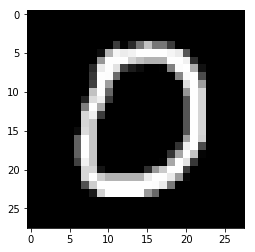

In [3]:
from dlinputs import tarrecords, utils
data = tarrecords.tariterator(open("testdata/sample.tgz"))
for sample in data:
    utils.print_sample(sample)
    imshow(sample["png"])
    break

Note that the `tariterator` operates over over any kind of stream, so you can open a URL. You can either use `urllib2` for that, or use `popen`:

    stream = os.popen("curl http://server/dataset")
    for sample in tarrecords.tariterator(stream):
        ...

The latter has the advantage that I/O and Python processing happen in separate threads.

In fact, the `gopen` submodule wraps up a bunch of ways of opening different locations, so you can use `gopen.open_source`.

__key__ '10'
cls 0
png float32 (28, 28)


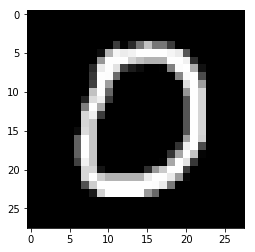

In [5]:
from dlinputs import gopen
for sample in gopen.open_source("testdata/sample.tgz"):
    utils.print_sample(sample)
    imshow(sample["png"])
    break

Note, however, that in normal code, you probably shouldn't use either `tariterator` or `open_source` directly, since they don't handle sharding. The sharded I/O functions below (`sharditerator`, `sharditerator_once`) work for non-sharded files as well, so you can use them for everything.

# Sharded Files

For larger datasets, sharding is a good idea. Shards are simply a list of consecutively numbered file names. The usual notation within this library is to use a file name or URL with an embedded string preceded by an "@":

    http://server/data-@000123.tgz
    
This URL refers to 123 shards with names of `http://server/data-000000.tgz` to `http://server/data-000122.tgz`

In [16]:
from dlinputs import paths
list(paths.path_shards("dir/prefix-@0004.tgz"))

['dir/prefix-0000.tgz',
 'dir/prefix-0001.tgz',
 'dir/prefix-0002.tgz',
 'dir/prefix-0003.tgz']

304


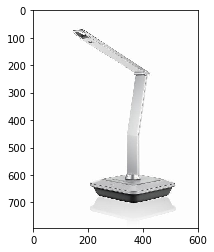

In [6]:
data = gopen.sharditerator("testdata/imagenet-@000001.tgz")
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

By default, `sharditerator` iterates over a dataset many times, shuffling the shards as it iterates. This is the right thing to do for training, but for testsets, you want to iterate over a dataset only once. The `sharditerator_once` function provides a convenient shorthand for this:

304


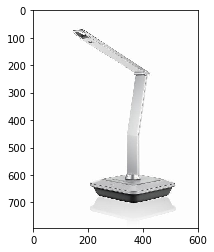

In [10]:
data = gopen.sharditerator_once("testdata/imagenet-@000001.tgz")
for sample in data:
    imshow(sample["png"])
    print sample["cls"]
    break

# Filters

Often, you want to perform transformations on training data. The `dlinputs.filters` library provides some convenient primitives for this. For example, to shuffle data, you can write:

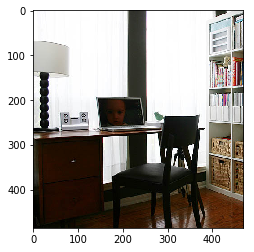

In [13]:
from dlinputs import filters
source = gopen.sharditerator("testdata/imagenet-@000001.tgz")
source = filters.shuffle(1000)(source)
sample = source.next()
imshow(sample["png"])

Note that the `filters.shuffle` function is a "curried" function. That is, it is two function calls; the first function call sets the parameters, the second applies the function to the actual iterator. This is how most functions in `filters` are written. It makes it easy to build pipelines by composing filters:

<type 'dict'>
__key__ <type 'list'> ['./59', './31', './15', './20', './69']
cls <type 'list'> [75, 500, 165, 904, 55]
png float32 (5, 256, 256, 3)
wnid <type 'list'> ['n02500267', 'n01644373', 'n02410509', 'n04590129', 'n02123
xml <type 'list'> ['<annotation>\n\t<folder>n02500267</folder>\n\t<filename>n0
[75, 500, 165, 904, 55]


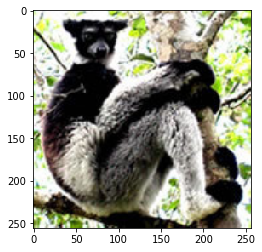

In [30]:
reload(filters)
reload(utils)
source = gopen.sharditerator("testdata/imagenet-@000001.tgz")
pipeline = filters.compose(
    filters.shuffle(1000),
    filters.standardized((256, 256)),
    filters.batched(5))
for sample in pipeline(source):
    print type(sample)
    utils.print_sample(sample)
    imshow(sample["png"][0])
    print sample["cls"]
    break